# Protests in Latin America
## Case study: Bolivia, Chile and Colombia

David Contreras &nbsp;&emsp;  <dlcontreras@andrew.cmu.edu><br>
Laura Goyeneche &ensp;  <lgoyenec@andrew.cmu.edu> <br>
Rosana Pineda   &ensp;&emsp;  <rpineda@andrew.cmu.edu><br>

Heinz College <br>
Carnegie Mellon University <br>

### Index 

1. <a href = "#int" >Introduction</a>
2. <a href = "#met" >Methodology</a>
3. <a href = "#dat" >Data Preparation</a>
4. <a href = "#sta" >Descriptive Statistics</a>
5. <a href = "#sen" >Sentiment Analysis</a>
6. <a href = "#sup" >Supervised Models</a>
7. <a href = "#uns" >Unsupervised Models</a>
8. <a href = "#con" >Conclusion</a>
9. <a href = "#ref" >References</a>

## <a id = "int">Introduction</a>

In the past decade, Latin America has presented a rise of center-right leaders. As a consequence, these governments have implemented neoliberalist policies that were expected to bring economic growth to the region. However, frustration among the people has increased as a result of corrupt and abusive governments that only benefit the most privileged. According to the World Bank the rating of transparency, accountability and corruption in Latin America’s public sector is 20% higher than the world’s average. 

During the last month we have seen a rise in the number of protests in Latin America, characterized by high levels of rage leading to violent outcomes. As an example, due to violent protests the Government of Chile declared a state of emergency. Therefore, it’s in the best interest of the governments in Latin America to understand the reasons behind the protests and predict them in advance to diminish their collateral damage. 

For this purpose we will be using Twitter's data related to the major protests occuring in Bolivia, Chile, and Colombia to (1) describe people’s perception towards the governments applying a sentiment analysis, (2) predict if a tweet is protest or no protest, and (3) use unsupervised machine learning models to identify clusters among the tweets.

The following document is divided in three main sections. First, we detail the methodology applied and provide a description of the tweets related and not related with protests. We explored trends in the data, geolocate individuals tweeting about protests in the region, identify the most frequent bigrams, and analyze the sentiment of tweets. Second, we predict whether a tweet is related with protests or not. Thrid and finally, we use unsupervised models to identify clusters among the tweets. 

## Libraries

In [1]:
# Twitter 
import twitterscraper as ts
from twitterscraper import query_tweets

# Language detection 
import langid  
import textblob
from langdetect import detect  

# Translation and Sentiment Analysis
import goslate
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Web scrapping
import re
from requests import get
from bs4 import BeautifulSoup

# Word Cloud
import wordcloud
from wordcloud import WordCloud

# Text analysis
import nltk
from nltk.util import ngrams
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import WhitespaceTokenizer

# TfidfVectorizer & Models
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import calinski_harabaz_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve,auc, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV,ShuffleSplit

# Location
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
geolocator = Nominatim()

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

import plotly as py
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Other
import os
import string
import inspect
import unidecode
import numpy as np
import collections
import pandas as pd
import datetime as dt
from scipy import interp
from itertools import cycle
from collections import Counter
from operator import itemgetter

pio.renderers.default = "notebook_connected"

INFO: {'User-Agent': 'Mozilla/5.0 (Windows NT 5.2; RW; rv:7.0a1) Gecko/20091211 SeaMonkey/9.23a1pre'}
C:\Users\lgoye\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


## <a id = "dat">Data Preparation</a>

For the data collection we scrapped data from Twitter using the library `twitterscraper`. This library allows us to identify tweets related with protests in Bolivia, Chile and Colombia. To do so, we refer to reputed news websites to identify words and hashtags related to our topic. From this search we identify six groups of words; protests and non-protests words and/or hashtags for each country. The following table shows some the search words and hashtags used for our query: 


| Country    | Protests   | Non Protests |
|------------|------------|--------------|
|   Bolivia  | `evomorales` <br> `primavera boliviana` <br> `fraude bolivia` `evodictador` <br> `masfraude` `sucre` <br> `revolucion pititas`| `cochamba` `travel` `espa` <br> `boliviatravel` `visitbolivia` <br> `lapazbolivia`|
|   Chile    | `chile desperto` <br> `primavera chile` `evasion masiva` <br> `chilesecanso` `pacosculiaos` <br> `noestamosenguerra`| `Valparaiso` `santiagodechile` <br> `chileno` `chilena` <br> `PuertoNatales` `travel chile`|
|   Colombia | `duquerenuncieya` `ParoNacional` <br> `duquerespeteelparo` <br> `elparosigue` `esmad` `dylan` <br> `nosestanmatando`| `LaLigaxRCN` `SeVinoMegaland` <br> `Besaton` `felizdomingo` <br> `BlackFridaycolombia`|


Most of the words related with protests referred to the current or former president (i.e. Duque in Colombia, Evo Morales in Bolivia) or what causes the protests: electoral fraud, murders, human rights abuses, police and swat abuses, among others. On the other hand, our query for tweets not related with protests referred to soccer, tourism and specific cities in each country. 

### Collection

Given the time it takes to scrap all the data used on the project, the following code illustrates the data collection procedure applied. For example, in Colombia protests started on November 21, 2019. As mentioned above, based on newspapers reports and twitters trends we identified relevant hashtags and relevant words like `#ParoNacional` (#NationalStrike), `#duqueasesino` (#DuqueMurderer), and `siyofueraduque` (#IfIwasDuque). Based on these words, we created a search list to query our tweets of interest. In addition, we searched for tweets that were not related with protests in each one of the countries. For instance, in Colombia topics related with soccer (`'#AmericaDeCali'`) and black friday (`'#BlackFridaycolombia'`) were also trendy during the same days. We repeated the same steps. 

<font size="2.5">*Please refer to our [Github](<https://github.com/lgoyenec/protests_latinamerica>), prepoc_query.ipynb for a detail notebook of the data extraction and preliminary engineering.*</font>

#### Example

In [2]:
# Definition of search filters
search     = ['paronaciona;']
begin_date = dt.date(2019, 11, 21)
end_date   = dt.date(2019, 12, 1)
limit      = 10
lang       = "spanish"

In [3]:
# Tweet objects
tweets = []
for i in search:
    tweets.extend(query_tweets(i, begindate = begin_date, enddate = end_date, limit = limit, lang = lang))

INFO: queries: ['paronaciona; since:2019-11-21 until:2019-11-22', 'paronaciona; since:2019-11-22 until:2019-11-23', 'paronaciona; since:2019-11-23 until:2019-11-24', 'paronaciona; since:2019-11-24 until:2019-11-25', 'paronaciona; since:2019-11-25 until:2019-11-26', 'paronaciona; since:2019-11-26 until:2019-11-27', 'paronaciona; since:2019-11-27 until:2019-11-28', 'paronaciona; since:2019-11-28 until:2019-11-29', 'paronaciona; since:2019-11-29 until:2019-11-30', 'paronaciona; since:2019-11-30 until:2019-12-01']
INFO: Got 10 tweets (10 new).
INFO: Got 20 tweets (10 new).
INFO: Got 30 tweets (10 new).
INFO: Got 40 tweets (10 new).
INFO: Got 50 tweets (10 new).
INFO: Got 60 tweets (10 new).
INFO: Got 70 tweets (10 new).
INFO: Got 80 tweets (10 new).
INFO: Got 90 tweets (10 new).
INFO: Got 100 tweets (10 new).


In [4]:
# Tweets as pandas Data Frame 
dfquery = pd.DataFrame(i.__dict__ for i in tweets)

In [5]:
# Variables 
dfquery.columns

Index(['has_media', 'hashtags', 'img_urls', 'is_replied', 'is_reply_to',
       'likes', 'links', 'parent_tweet_id', 'replies', 'reply_to_users',
       'retweets', 'screen_name', 'text', 'text_html', 'timestamp',
       'timestamp_epochs', 'tweet_id', 'tweet_url', 'user_id', 'username',
       'video_url'],
      dtype='object')

We can observe that the query provides us with variables like the tweet text, the user they mentioned and the hashtags used. Moreover, they provide us with the time and day the tweet was published and the the user and tweet id in case we want to use them to scrap more information from the other classes and subclasses that the library has. 

In [6]:
# Let's observe some of the variables of interest
dfquery[["user_id","username","text","hashtags","timestamp"]].head()

,user_id,username,text,hashtags,timestamp
0,303552459,Mario Humberto Posso,Que tristeza me da ver como los corruptos paga...,[paronaciona],2019-12-11 08:47:12
1,151214000,Andres S.,El ESMAD haciendo otra vez violentando a la ge...,[paronaciona],2019-12-11 00:20:15
2,913836071724576768,Alejandro Hernández,"Es que TODOS los políticos son lo mismo, única...",[],2019-12-09 08:01:20
3,1132441929478746112,Tía Política,Ya no importa que muchos no sepan\n\n- Que el ...,"[ParoNacionalColombia, ParoNaciona]",2019-12-08 21:51:32
4,71342194,virgilio reales,"Tu #paronaciona, parece que dijera Paranoia, s...",[paronaciona],2019-12-06 14:09:21


From the query in each country we eliminate the duplicates, randomly selected **90,000** tweets per country balanced by protests, and clean the data: remove usernames, URLs, hasthtags from text variable, emojis, number, stopwords, convert text to lowercase, remove empty tokens and words with only one words, and lemmatize text.

In [7]:
# Define function to retrieve @users in a tweet:
def mentioned_users(string):
    usernames = re.findall('@[^\s]+', string)
    return usernames

In [8]:
# Create a new column and apply the function on the column 'text'
dfquery['mentioned_users'] = dfquery['text'].apply(lambda x: mentioned_users(x))

In [9]:
# Define Emoji_patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [10]:
# Define function to clean text:
def clean_text(text):
    
    # Apply regex expressions first before converting string to list of tokens/words:
    # 1. Remove @usernames
    text = re.sub('@[^\s]+', '', text)
    
    # 2. Remove URLs
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', text)
    
    # 3. Remove hashtags entirely i.e. #hashtags
    text = re.sub(r'#([^\s]+)', '', text)
    
    # 4. Remove emojis
    text = emoji_pattern.sub(r'', text)
    
    # 5. Convert text to lowercase
    text = text.lower()
    
    # 6. Tokenize text and remove punctuation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # 7. Remove numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # 8. Remove stop words
    stop = stopwords.words('spanish')
    text = [x for x in text if x not in stop]
    
    # 9. Remove empty tokens
    text = [t for t in text if len(t) > 0]
    
    # 10. Lemmatize text
    text = [WordNetLemmatizer().lemmatize(t) for t in text]
    
    # 11. Remove words with only one letter
    text = [t for t in text if len(t) > 1]
    
    # 12. Join all
    text       = " ".join(text)
    wordsPunct = RegexpTokenizer(r'\w+')
    text       = wordsPunct.tokenize(text)
    
    return(text)

In [11]:
# Create variable for clean tweet
dfquery['cleaned_text'] = dfquery['text'].apply(lambda x: clean_text(x))

In [12]:
# Remove empty tweets
dfquery.dropna(subset = ['cleaned_text'], inplace = True)

### Feature Engineering

From the collection procedure we created two datasets for each country corresponding to tweets related with and without protests. We use those datasets to complete our data engineering and create one dataset with the features of interest. 

1. Validate that all the scraped tweets are in spanish
2. Create protest and country id 
3. Append datasets
4. Keep variables of interest
5. Create clean text with hashtags and mentioned users
6. Remove accents

In [13]:
# Current and data working directory
cwd = os.getcwd()
dwd = cwd + "\\data_csv\\"

In [14]:
# Import csv data sets
bolP  = pd.read_csv(dwd + "querybol_p.csv"   , low_memory = False)
bolNP = pd.read_csv(dwd + "querybol_np.csv"  , low_memory = False)
chiP  = pd.read_csv(dwd + "querychil.csv"    , low_memory = False)
chiNP = pd.read_csv(dwd + "querychil_np.csv" , low_memory = False)
colP  = pd.read_csv(dwd + "querycol_p.csv"   , low_memory = False)
colNP = pd.read_csv(dwd + "querycol_nonp.csv", low_memory = False)

#### Language validation

After organizing the data, we validate whether the tweets were in spanish or not. Because we used a diverse pool of words for our query, some tweets were in japanese, english, catalan and not related with our topic of interest. Filtering the tweets increases our confident on the query tweets. 

It is important to point out that the function `langid_safe` might take between 15-30 minutes running. We create a dataset `tweetslat.csv` with the results of *Language validation* and *Features selection* sections. The following code is an example with the first 10 observations from each dataset.

<font size="2.5">*Please refer to our [Github](<https://github.com/lgoyenec/protests_latinamerica>), prepoc_dataeng.ipynb for a detail notebook of the data extraction and preliminary engineering.*</font>

In [15]:
# Select first 10 observations of each dataset
bolP  = bolP .iloc[:10]
bolNP = bolNP.iloc[:10]
chiP  = chiP .iloc[:10]
chiNP = chiNP.iloc[:10]
colP  = colP .iloc[:10]
colNP = colNP.iloc[:10]

In [16]:
# Create function to evaluate language
# Source: http://blog.manugarri.com/sentiment-analysis-in-spanish/

def langid_safe(tweet):  
    try:
        return langid.classify(tweet)[0]
    except Exception as e:
        pass

In [17]:
# Lists of dataframes
pdlist = [bolP, bolNP, chiP, chiNP, colP, colNP]

In [18]:
# Create language id 
for data in pdlist:
    data['lang_langid'] = data.text.apply(langid_safe)

In [19]:
# Results
bolP[["text","lang_langid"]].iloc[5:]

,text,lang_langid
5,No se olvide que esta rigiendo la LEY DE SEGUR...,es
6,Este es el mejor momento de Bolivia! Se fue el...,es
7,"Cual es el clarin chileno? TVN, Meganoticias, ...",es
8,Porfavor que alguien le diga a esta señora que...,es
9,"*La OEA, UE y los *Bolivianos*",es


In [20]:
# Keep tweets only in spanish
bolP  = bolP [bolP.lang_langid  == "es"]
bolNP = bolNP[bolNP.lang_langid == "es"]
chiP  = chiP [chiP.lang_langid  == "es"]
chiNP = chiNP[chiNP.lang_langid == "es"]
colP  = colP [colP.lang_langid  == "es"]
colNP = colNP[colNP.lang_langid == "es"]

In [21]:
# Validate how balance are the datasets
bolP.shape, bolNP.shape, chiP.shape, chiNP.shape, colP.shape, colNP.shape

((8, 24), (8, 24), (9, 24), (10, 24), (9, 24), (9, 24))

#### Features selection

In addition, to validate the language, we conduct features selection and engineering. This corresponds to an example of what we did with the complete data. 

In [22]:
# Create protest and country id 
bolP ["country"], bolP ["protest"] = ["bol",1]
bolNP["country"], bolNP["protest"] = ["bol",0]
chiP ["country"], chiP ["protest"] = ["chi",1] 
chiNP["country"], chiNP["protest"] = ["chi",0]
colP ["country"], colP ["protest"] = ["col",1] 
colNP["country"], colNP["protest"] = ["col",0]

In [23]:
# Append datasets
tweetslat = bolP.copy()
tweetslat = tweetslat.append(bolNP)
tweetslat = tweetslat.append(chiP)
tweetslat = tweetslat.append(chiNP)
tweetslat = tweetslat.append(colP)
tweetslat = tweetslat.append(colNP)

In [24]:
tweetslat.shape

(53, 26)

In [25]:
# Select variable of interest
tweetslat = tweetslat[['user_id','country','protest',
                       'timestamp','text','hashtags','mentioned_users',
                       'likes','retweets',
                       'cleaned_text']]

#### Final cleaning

In [26]:
# String variables to lowercase 
tweetslat['hashtags']        = tweetslat['hashtags'].apply(str.lower)
tweetslat['mentioned_users'] = tweetslat['mentioned_users'].apply(str.lower)

# Remove @ on mentioned users
tweetslat['mentioned_users'] = tweetslat['mentioned_users'].str.replace('@','')

# Hashtags, mentioned_users and cleaned_test from str list to list
tweetslat['hashtags']        = tweetslat['hashtags'].str.replace("'","").str.strip("][").str.split(",")
tweetslat['mentioned_users'] = tweetslat['mentioned_users'].str.replace("'","").str.strip("][").str.split(",")
tweetslat['cleaned_text']    = tweetslat['cleaned_text'].str.replace("'","").str.strip("][").str.split(",")

# Merge cleaned_text, hashtags and mentioned_users
tweetslat['clean_text_2']    = tweetslat['hashtags'] + tweetslat['mentioned_users'] + tweetslat['cleaned_text']

# Remove empty elements and accents
tweetslat['clean_text_2']    = tweetslat['clean_text_2'].apply(lambda x: [unidecode.unidecode(i) for i in x if len(i) > 0])

## <a id = "sta">Descriptive Statistics</a>

To understand better the situation we analyze the tweets in each one of the countries. We compare the usage of twitter across countries, identify patterns by hour, day and month. In addition, we identify which words and hashtags were common in each country. 

In [27]:
# Import csv final data
tweetslat  = pd.read_csv(dwd + "tweetslat.csv", low_memory = False)

In [28]:
# Columns 
tweetslat.columns

Index(['user_id', 'country', 'protest', 'timestamp', 'text', 'hashtags',
       'mentioned_users', 'likes', 'retweets', 'cleaned_text', 'clean_text_2'],
      dtype='object')

In [29]:
# Transform and create additional variables for our descriptive statistics
tweetslat['clean_text_2'] = tweetslat['clean_text_2'].str.replace("'","").str.strip("][").str.split(",")
tweetslat['words']        = tweetslat['clean_text_2'].apply(lambda x: ''.join(x))
tweetslat['timestamp']    = pd.to_datetime(tweetslat['timestamp'])

In [30]:
# Create time variables
tweetslat['hour']   = pd.to_datetime(tweetslat['timestamp']).dt.hour
tweetslat['month']  = pd.to_datetime(tweetslat['timestamp']).dt.month
tweetslat['day']    = pd.to_datetime(tweetslat['timestamp']).dt.day

In [31]:
# Create constant variable for frequency plots
tweetslat['n'] = 1

### Number of tweets by country and protest id

The following table illustrates that our data is balanced across countries and the protests id. Out of 199,539 tweets, 53% referred to protests, around 60% relate to the situation in Bolivia and Colombia (30% each).

In [32]:
pd.crosstab(tweetslat['country'],tweetslat['protest'], rownames = ["Country"], colnames = ["Protests"])

Protests,0,1
Country,,
bol,23081,37117
chi,37394,39325
col,33551,29071


### Count of tweets by hour

We can observe that there's a higher number of tweets related to protests after 8:00 pm. Also, the figures shows that after 3:00 pm the number of non-protests tweets are uniform, the protests tweets increase exponentially. 

In [33]:
temp = tweetslat.groupby(['country','hour','protest'])['n'].count().reset_index()

px.bar(temp, 
       x = 'hour', 
       y = 'n', 
       facet_col = 'protest',
       labels    = {'n':'Count', 'hour':'Hour','country':'Country'},
       color     = 'country',
       width     = 900, height = 400,
       color_discrete_sequence  = ["#031926","#468189","#63B4D1"]).show()

### Count of tweets by day

As expected, we observe that while the number of non-protests tweets is constant (accounting for the evident variability) across days, the number of protests tweets increase after the 20th. This trend is related with the news and the days when the protests took place.

In [34]:
temp = tweetslat.groupby(['country','day','protest'])['n'].count().reset_index()

px.line(temp, 
        x = 'day', 
        y = 'n', 
        facet_col = 'protest',
        labels    = {'n':'Count', 'day':'Day','country':'Country'},
        color     = 'country',
        width     = 900, height = 400,
        color_discrete_sequence  = ["#031926","#468189","#63B4D1"]).show()

### Count of tweets by month

This plot helps us to determine whether our data collection was correct or not. We expected that the number of protests tweets were posiitive from October until today. The non-protests tweets graph shows that individuals have referred to the words and hashtags year round. 

In [35]:
temp = tweetslat.groupby(['country','month','protest'])['n'].count().reset_index()

px.bar(temp, 
       x = 'month', 
       y = 'n', 
       facet_col = 'protest',
       labels    = {'n':'Count', 'month':'Month','country':'Country'},
       color     = 'country',
       width     = 900, height = 400,
       color_discrete_sequence  = ["#031926","#468189","#63B4D1"]).show()

### Word clouds by country

As mentined before, most of the words related with protests referred to the current or former president (i.e. Duque in Colombia, Evo Morales in Bolivia) or what causes the protests: electoral fraud, murders, human rights abuses, police and swat abuses, among others.

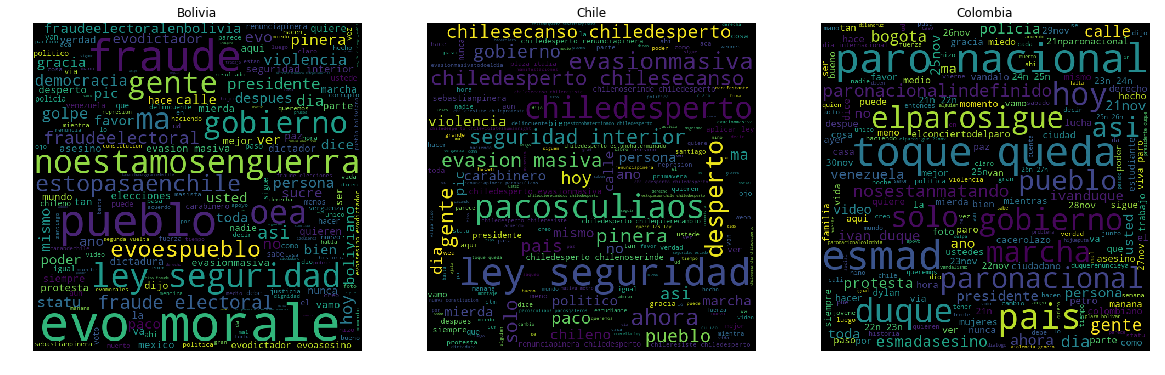

In [36]:
names = ["bol", "chi", "col"]
plt.figure(figsize=(20,20))

for i,j in enumerate(names): 
    
    # Select data per country
    data = tweetslat.loc[(tweetslat.country == j) & (tweetslat.protest == 1),"words"]
    
    # Define words to eliminate
    if j == "bol":
        name = "Bolivia"
        omit = set({"bolivia", "si", "ahora", "twitter", "com", "pais", "chile", "solo","pacosculiaos","chiledesperto","chilesecanso"})
    elif j == "chi":
        name = "Chile"
        omit = set({"twitter", "com", "si","chile"})
    else:
        name = "Colombia"
        omit = set({"twitter", "com", "colombia", "si", "pic"})
    
    # Plot 
    plt.subplot(1,3,i+1).set_title(name)
    plt.plot()
    cloud = WordCloud(stopwords = omit, width = 600, height = 600).generate(' '.join(data)).to_image()
    plt.imshow(cloud)
    plt.axis("off")

plt.show()

### Top hashtags by country

As well, the top hashtags are also related to the causes of the protests. It is important to point out, that some of the frequent words and hashtags are correlated with the ones we used to scrapped tweets. We might be leaving out some other tweets that might also be related with the protests in the countries of interest. 

#### Bolivia

In [37]:
omit  = set({"bolivia", "si", "ahora", "twitter", "com", "pais", "chile", "solo","pacosculiaos","chiledesperto","chilesecanso"})
words = [j.strip() for lword in tweetslat.loc[(tweetslat['country'] == "bol") & (tweetslat['protest'] == 1),'clean_text_2'] for j in lword if j.strip() not in omit]
words = pd.DataFrame({"words": words, "n": 1})
words = words.groupby(["words"])['n'].count().reset_index()
words = words.nlargest(25,'n')

In [38]:
px.bar(words, 
       x      = "words",
       y      = "n",
       labels = {"n": "Frequency"},
       width  = 900, height = 400,
       color_discrete_sequence  = ["#63B4D1"]).show()

#### Chile

In [39]:
omit  = set({"chile","si","ser","solo","asi","santiagodechile"})
words = [j.strip() for lword in tweetslat.loc[(tweetslat['country'] == "chi") & (tweetslat['protest'] == 1),'clean_text_2'] for j in lword if j.strip() not in omit]
words = pd.DataFrame({"words": words, "n": 1})
words = words.groupby(["words"])['n'].count().reset_index()
words = words.nlargest(25,'n')

In [40]:
px.bar(words, 
       x      = "words",
       y      = "n",
       labels = {"n": "Frequency"},
       width  = 900, height = 400,
       color_discrete_sequence  = ["#63B4D1"]).show()

#### Colombia

In [41]:
omit  = set({"colombia","pais","si"})
words = [j.strip() for lword in tweetslat.loc[(tweetslat['country'] == "col") & (tweetslat['protest'] == 1),'clean_text_2'] for j in lword if j.strip() not in omit]
words = pd.DataFrame({"words": words, "n": 1})
words = words.groupby(["words"])['n'].count().reset_index()
words = words.nlargest(25,'n')

In [42]:
px.bar(words, 
       x      = "words",
       y      = "n",
       labels = {"n": "Frequency"},
       width  = 900, height = 400,
       color_discrete_sequence  = ["#63B4D1"]).show()

### N-grams 

In the fields of computational linguistics and probability, an n-gram is a contiguous sequence of `n` items from a given sample of text or speech. This is useful because it gives us the words that are more likely to occur together. For purposes of this project, we would like to know what are the pair of words that are more likely to go together in tweets classified as 'protest' and 'no protest'.

In [43]:
# Select tweets related with protest
protest = tweetslat[tweetslat['protest']==1]
protest = list(protest['clean_text_2'])

In [44]:
# Create flatten list
flat_p = []
for sublist in protest:
    for val in sublist:
        flat_p.append(val)

In [45]:
# Calculate bi-grams
bi = ngrams(flat_p,2)
bi_freq = collections.Counter(bi)
bi_freq.most_common(20)

[(('  ley', '  seguridad'), 4843),
 (('  twitter', '  com'), 1894),
 (('  seguridad', '  interior'), 1823),
 (('  toque', '  queda'), 1765),
 (('  pic', '  twitter'), 1693),
 (('  chiledesperto', '  chilesecanso'), 1609),
 (('  evo', '  morale'), 1564),
 (('  chile', '  desperto'), 1546),
 (('  paro', '  nacional'), 1537),
 (('  evasion', '  masiva'), 1456),
 (('  chilesecanso', '  chiledesperto'), 1064),
 (('  fraude', '  electoral'), 941),
 (('chilesecanso', '  chiledesperto'), 793),
 (('chiledesperto', '  chilesecanso'), 760),
 (('  aplicar', '  ley'), 500),
 (('  chiledesperto', '  chilenoserinde'), 489),
 (('  plaza', '  italia'), 481),
 (('  ivan', '  duque'), 442),
 (('  chile', '  chiledesperto'), 423),
 (('ley', '  seguridad'), 397)]

As we can see, the two most likely words to go together in tweets classified as 'protest' are: 
* Internal security 
* Curfew (two words in spanish) 
* Apply law 
* National strike 
* Massive evasion 
* Names of popular figures such as `Evo Morales` and `Ivan Duque`

In [46]:
# Select tweets not related with protest
nprotest = tweetslat[tweetslat['protest']==0]
nprotest = list(nprotest['clean_text_2'])

In [47]:
# Create flatten list
flat_np = []
for sublist in nprotest:
    for val in sublist:
        flat_np.append(val)

In [48]:
# Calculate bi-grams
nbi = ngrams(flat_np,2)
nbi_freq = collections.Counter(nbi)
nbi_freq.most_common(20)

[(('  twitter', '  com'), 2214),
 (('  pic', '  twitter'), 1975),
 (('  futbol', '  chileno'), 761),
 (('  chileno', 'conversaciones'), 655),
 (('  chile', '  santiagodechile'), 543),
 (('  santiagodechile', '  chile'), 513),
 (('  santiago', '  chile'), 505),
 (('  cochabamba', '  lapaz'), 457),
 (('  venezuela', '  latinoamerica'), 417),
 (('  santacruzdelasierra', '  cochabamba'), 402),
 (('  santiago', '  santiagodechile'), 368),
 (('  america', '  cali'), 365),
 (('  latinoamerica', '  eeuu'), 337),
 (('  bolivia', '  santacruzdelasierra'), 316),
 (('  oea', '  onu'), 315),
 (('  unioneuropea', '  ue'), 312),
 (('  ue', '  noticias'), 312),
 (('  unasur', '  oea'), 304),
 (('  oea', '  celac'), 303),
 (('  celac', '  onu'), 303)]

### Mapping

Finally, let's visualize the location of a random sample of users. One of the disadvantages of working with twitterscrapper is that it doesn't include detailed geographical information per tweet, this can only be obtained by user. So, if we want to know where the tweets come from, we could use as a proxy the user's location. The suggested way to go about it is to use BeautifulSoup to go through each user's profile, extract the location (if filled in) and then geocode that information. This way is a little bit more specific than querying for specific user information. The problem with this is that running this function takes a lot of time, so we will do it only for 1,000 unique twitter users.

In [49]:
# Create dataframe with list of unique users
data  = pd.read_csv(dwd + "user_loc.csv")
data  = data.iloc[:10]
loc   = list(data['location'])
coord = []

for l in loc:
    split   = l.split(',')
    located = geolocator.geocode(split[0], timeout=200)
    coord.append(located)

latitude  = []
longitude = []
place     = []
for c in coord:
    lat = c[1][0]
    lon = c[1][1]
    p   = c[0][0]
    latitude.append(lat)
    longitude.append(lon)
    place.append(c)
    
count = []
for l in loc:
    count.append(1)
    
df = pd.DataFrame(list(zip(place, latitude, longitude, count)), columns = ['place', 'latitude', 'longitude', 'count'])

df

,place,latitude,longitude,count
0,"(Lima, Peru, (-12.0621065, -77.0365256))",-12.062107,-77.036526,1
1,"(Sucre, Provincia Oropeza, Chuquisaca, 9999, B...",-19.047725,-65.259431,1
2,"(Guadalajara, Jalisco, 44360, México, (20.6720...",20.672037,-103.338396,1
3,"(Caracas, Municipio Libertador, Distrito Capit...",10.506098,-66.914602,1
4,"(Monterrey, Nuevo León, México, (25.63978365, ...",25.639784,-100.293102,1
5,"(St. Gallen, Wahlkreis St. Gallen, Sankt Galle...",47.425059,9.376588,1
6,"(Puebla, México, (18.833333, -98.0))",18.833333,-98.000000,1
7,"(La Paz, Provincia Pedro Domingo Murillo, La P...",-16.495545,-68.133623,1
8,"(Buenos Aires, Ciudad Autónoma de Buenos Aires...",-34.607562,-58.437076,1
9,"(Ciudad de México, Cuauhtémoc, Ciudad de Méxic...",19.432601,-99.133342,1


In [50]:
data  = pd.read_csv(dwd + "geofile.csv")

fig = px.scatter_mapbox(data, 
                        lat  = "latitude", 
                        lon  = "longitude", 
                        zoom = 2.5, 
                        color_discrete_sequence  = ["#63B4D1"])

fig.update_layout(mapbox_style = "carto-positron", 
                  margin       = {"r":0, "t":0, "l":0, "b":0})
fig.show()

## <a id = "sen">Sentiment Analysis</a>

In addition, to descriptive statistics we analyze the sentiment of the tweets. to do so we first translate the tweets to spanish, given that the available libraries analyze tweets in english. As well as in previous sections, due to memory limitations, we analyze only the tweets related to Bolivia. 

### Translation

To translate allt the tweets related to Bolivia we needed more than 20 hours. To illustrate the methodology, we are using 5 tweets. As observe we used the tweets text and translated to spanish. A disantavantage of the following code is that is not able to recognize the hashtags and traduce them to spanish. For future work, we should identify and split the hashtags into words so that our translation is more accurate and our sentiment analysis catch their sentiment

In [51]:
# Call translator
gs = goslate.Goslate()

In [52]:
# Create copy of column with both text, hashtags and most mentioned users
temp = tweetslat.words.iloc[:5].copy()

In [53]:
# Translate text
wordstrans = []
for i in temp:
    try:
        eng = gs.translate(i, 'en')
        wordstrans.append(eng)
    except:
        pass

### Analysis Bolivia

In [54]:
# Import csv words translated
wordstrans = pd.read_csv(dwd + "wordstrans.csv", low_memory = False)
wordstrans = list(wordstrans['0'])

Based on another [sentiment analysis](https://towardsdatascience.com/almost-real-time-twitter-sentiment-analysis-with-tweep-vader-f88ed5b93b1c), we construct the function `sentiment` to classify tweets in negative, neutral and positive. In addition, we also create a list with the sentiment score to understand its distribution. 

In [55]:
# Function to calculate a discrete score sentiment
def sentiment(tweet):
    analyser = SentimentIntensityAnalyzer()
    score    = analyser.polarity_scores(tweet)
    thres    = score['compound']
    if thres >= 0.05:
        return 1
    elif (thres > -0.05) and (thres < 0.05):
        return 0
    else:
        return -1

In [56]:
# Define analyser 
analyser = SentimentIntensityAnalyzer()

# Define list of discrete and continuos score
score    = []
scorecon = []

# Create lists
for i in wordstrans:
    if str(i) == "nan":
        score.append(9)
        scorecon.append(9)
    else:
        score.append(sentiment(i))
        scorecon.append(analyser.polarity_scores(i)['compound'])

First, we plotted the scores distirbution excluding `nan` values and neutral tweets, given that the latter corresponds to a larger percentage. We observe that there is a large portion of tweets classified as positive. This could be because most of the negativity is placed on the hashtags rather than in the text.

In [57]:
# Data
sc = pd.DataFrame({"score": scorecon})
sc = sc[sc.score != 9.]                # omit nan rows
sc = sc[sc.score != 0.]                # omit neutral tweets

# Histogram of score
px.histogram(sc, 
             x      = "score",  
             nbins  = 50,
             title  = "Scores distribution",
             labels = {"count": "Frequency", "score": "Score"},
             width  = 900, height = 400,
             color_discrete_sequence  = ["#63B4D1"]).show()

When we observe the differences between negative, neutral and positive tweets, we observe that 20% are negative and 40% positive. Again, this difference might be explain by the hashtags that were not translated. 

In [58]:
# Data  
data = pd.DataFrame({"score": score})
data = data.join(tweetslat[["country","mentioned_users","hashtags","n","text","words"]].copy())
data = data[data.score != 9]

# Collapse data
temp = data.groupby(['country','score'])['n'].count().reset_index()
temp.score = pd.DataFrame(["Negative","Neutral","Positive"])

# Bar plot bedrooms
px.bar(temp, 
       x      = "score",
       y      = "n",
       title  = "General Sentiment of Tweets related with Protests",
       labels = {"n": "Frequency", "score": "Score"},
       width  = 800, height = 400,
       color_discrete_sequence  = ["#63B4D1"]).show()

Given that sentiment analysis classifies most of the tweets as neutral of positive, we explored the top negative and positive hashtags to identify differences across them. We were wondering whether the sentiment score was accurate or not. 

#### Top Negative Hashtags

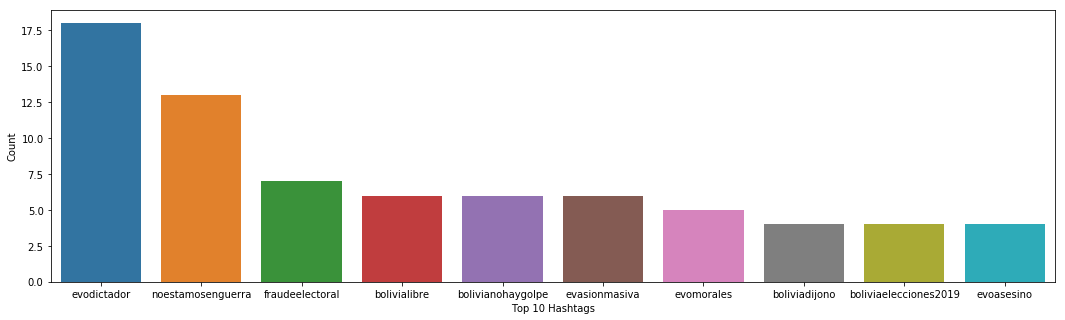

In [59]:
# Create data to be plotted
temp     = data[data.score == -1].hashtags.str.replace("'","").str.strip("][").str.split(",").apply(lambda x: [i.strip() for i in x])
omit     = set({"","renunciapiñera","fraudeelectoralenbolivia","chiledesperto","chiledespertó","chilequierecambios","chileresiste","chilenoserinde","chileprotesta","estopasaenchile","renunciapiñerahttps","bolivia", "si", "ahora", "twitter", "com", "pais", "chile", "solo","pacosculiaos","chiledesperto","chilesecanso"})
hashtags = [j for row in temp for j in row if j not in omit]
hashpd   = pd.DataFrame({"hashtags": hashtags, "n": 1})
hashpd   = hashpd.groupby(["hashtags"])['n'].count().reset_index()
hashpd   = hashpd.nlargest(10,'n')

plt.figure(figsize = (18,5))
fig = sns.barplot(data = hashpd, x = "hashtags", y = "n")
fig.set(ylabel = "Count", xlabel = "Top 10 Hashtags")
plt.show()

In [60]:
list(data[data.score == -1].words)[30]

'nohaygolpeenbolivia  nofuegolpefuefraude  evodictador sinverguenza  muerto  persona  manos  policia  ffaa  embargo  lado  cobraron  vida  persona  comandante  policia  descarado  dictador  asesino'

#### Top Positive Hashtags

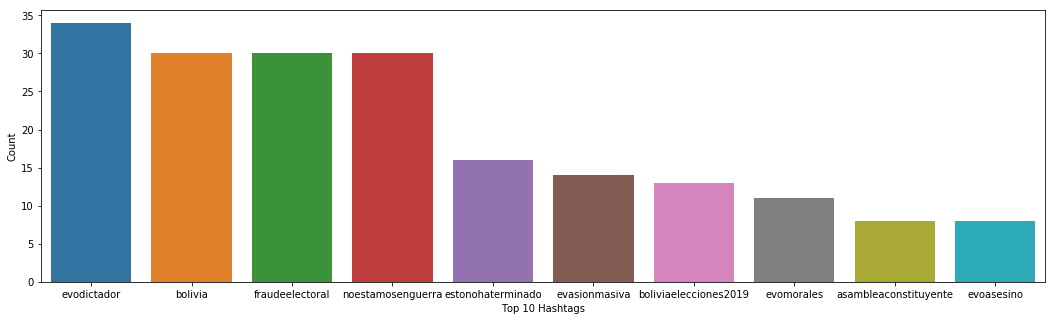

In [61]:
# Create data to be plotted
temp     = data[data.score == 1].hashtags.str.replace("'","").str.strip("][").str.split(",").apply(lambda x: [i.strip() for i in x])
omit     = set({"piñerarenuncia","","chiledesperto","estopasaenchile","chilesecanso","chile","renunciapiñera","chiledespertó","pacosculiaos","chileresiste","fraudeelectoralenbolivia"})
hashtags = [j for row in temp for j in row if j not in omit]
hashpd   = pd.DataFrame({"hashtags": hashtags, "n": 1})
hashpd   = hashpd.groupby(["hashtags"])['n'].count().reset_index()
hashpd   = hashpd.nlargest(10,'n')

plt.figure(figsize = (18,5))
fig = sns.barplot(data = hashpd, x = "hashtags", y = "n")
fig.set(ylabel = "Count", xlabel = "Top 10 Hashtags")
plt.show()

In [62]:
list(data[data.score == 1].words)[13]

'otono  latinoamericano  haiti  bolivia  peru  ecuador  venezuela  honduras  mexico  chile  brasil  van  sumando  asi  primavera  arabe'

From the top hashtags and the tweets classified as negative or positive, we observed that the negative used words as murdered, freedom, fraud more often that those classified as positive. Moreover, one additional reason that could justify why they are more tweets classified as neutral and positive is that most of the individuals are not using negative words in their tweets, they are clearly expressing their negative opinion towards the governments, by 

## <a id = "sup">Supervised Models</a>

In this section, we are going to implement a supervised learning statistical model for classify the tweets in *protest* or *non-protest*. For this purpose, we are going to make an additional pre-processing to the text, and train three supervised models: a Naive Bayes, Logistic Regression and Random Forest. Finally, we are going to build the ROC curve and evaluate the performance of each model using the AUC. Before that, we have to make additional feature engineering to the text, in order to build the TD-IDF matrix:

In [63]:
%%capture
# Select variables of interest
data_models = tweetslat[['protest', 'text']]

# Additional changes
data_models['text_parsed1'] = data_models['text'].str.replace("\r", " ")     # eliminate the \r
data_models['text_parsed1'] = data_models['text'].str.replace("\n", " ")     # eliminate the \n
data_models['text_parsed1'] = data_models['text'].str.replace("    ", " ")   # eliminate extra space.
data_models['text_parsed1'] = data_models['text'].str.replace('"', '')       # eliminate the ""
data_models['text_parsed1'] = data_models['text'].str.lower()                # lower case

punctuation_signs = list("?:!.,;")                                           # create a small list of punctuation signs

for punct_sign in punctuation_signs: 
    data_models['text_parsed1'] = data_models['text_parsed1'].str.replace(punct_sign, '') # remove punctuation

data_models['text_parsed1'] = data_models['text_parsed1'].str.replace("'s", "")   

nltk.download('punkt')                              # Downloading punkt and wordnet from NLTK
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()                    # Saving the lemmatizer into an object

lemm_list = []

for row in data_models['text_parsed1'].values.tolist():
    lemmatized_list = []                            # Create an empty list containing lemmatized words
    text       = row                                # Save the text and its words into an object
    text_words = text.split(" ")
    
    for word in text_words:                         # Iterate through every word to lemmatize
        lemmatized_list.append(lemmatizer.lemmatize(word, pos="v"))
    
    lemmatized_text = " ".join(lemmatized_list)     # Join the list
    lemm_list.append(lemmatized_text)               # Append to the list containing the texts
    
data_models['text_parsed2'] = lemm_list

nltk.download('stopwords')                                              # Download the dictionary of stopwords
stop_words = list(stopwords.words('spanish'))                           # select the dictionary of english
regex      = r"\b" + word + r"\b"                                       # build a regular expression for eliminate stop

for stop_word in stop_words:                                            # identify and eliminate stopwords in the text
    regex_stopword = r"\b" + stop_word + r"\b"
    data_models['text_parsed3'] = data_models['text_parsed2'].str.replace(regex_stopword, '')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lgoye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lgoye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lgoye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


After we have our input cleaned, we are ready to implement our statistical learning models. We will start spliting the data between train and test sets, using Skilearn library:

In [64]:
# Create train and test 
X_train, X_test, y_train, y_test = train_test_split(data_models['text_parsed3'],  # split the train, test data
                                                    data_models['protest'],
                                                    test_size=0.30,               # 30% for the test data
                                                    random_state=8)

In [65]:
# Create TFIDF matrix
min_df       = 10      # minimum inverse term frequency 
max_df       = 1.      # maximum inverse term frequency to be considered
max_features = 50      # only consider 300 highest words with TF-IDF

fidf = TfidfVectorizer(lowercase = False, max_features = max_features)
features_train = fidf.fit_transform(X_train).toarray()                  # apply the count vectorizer to both train and
labels_train = y_train                                                  # test datasets and obtain the size of the matrix
print(features_train.shape)

features_test = fidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(139677, 50)
(59862, 50)


### Naive Bayes

We are going to build our Naive Bayes classificator, using skilearn library. We are going, after that, predict the labels for the test dataset and plot the confussion matrix:

In [66]:
gnb = GaussianNB()
gnb_fit = gnb.fit(features_train, labels_train)
gnb_pred = gnb.predict(features_test)

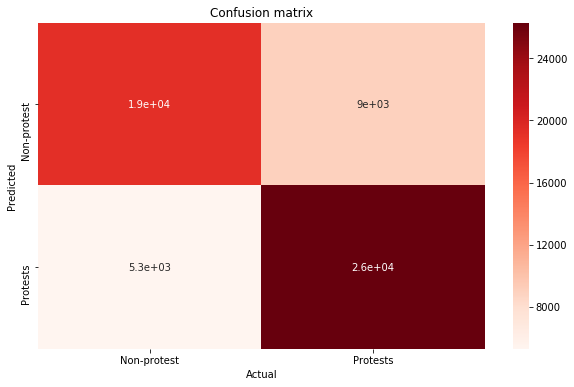

In [67]:
aux_data = pd.DataFrame({'Type':["Non-protest", "Protests"],
                       'product_code':[0,1]})
conf_matrix = confusion_matrix(labels_test, gnb_pred)
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_data['Type'].values, 
            yticklabels=aux_data['Type'].values,
            cmap="Reds")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

### Logistic Regression

Now, we are going to implement a logistic regression. We are going to use a random search for the hyperparameter tunning:

In [68]:
%%capture 
lrc = LogisticRegression()
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
random_search = RandomizedSearchCV(estimator=lrc,                           # Definition of the random search
                                   param_distributions=hyperparameters,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=5, 
                                   verbose=1, 
                                   random_state=8)
random_search.fit(features_train, labels_train)                               # Fit the random search model
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

After the hyperparameter tunning, we print the results:

In [69]:
random_search.best_params_

{'penalty': 'l1', 'C': 59.94842503189409}

Finally, we are ready to fit our logit model with our parameters:

In [70]:
%%capture
lrc = LogisticRegression(penalty = 'l1', C = 1.0)
lrc_fit = lrc.fit(features_train, labels_train)
lrc_pred = lrc.predict(features_test)

And we build the confussion matrix:

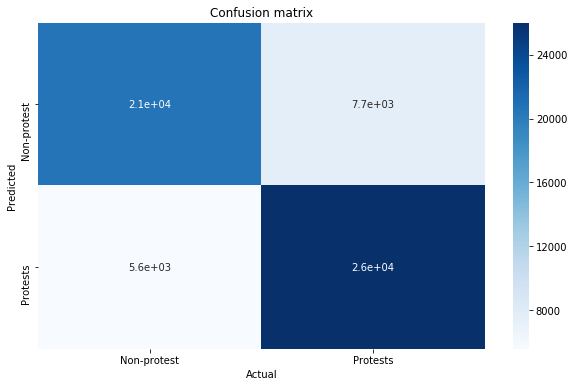

In [71]:
aux_data = pd.DataFrame({'Type':["Non-protest", "Protests"],
                       'product_code':[0,1]})
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_data['Type'].values, 
            yticklabels=aux_data['Type'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

### Random Forest

Finally, we are ready to build our random forest model. Because of computational restrictions, we are going to use the default parameters, but it would be better if we were able to use a hyperparameter tunning similar to logistic regression:

In [72]:
%%capture
clf = RandomForestClassifier()
clf_fit = clf.fit(features_train, labels_train)
clf_pred = clf.predict(features_test)

In [73]:
prec_clf = precision_recall_fscore_support(labels_test, gnb_pred)

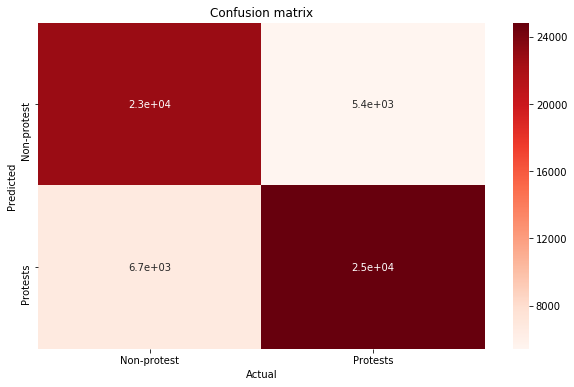

In [74]:
aux_data = pd.DataFrame({'Type':["Non-protest", "Protests"],
                       'product_code':[0,1]})
conf_matrix = confusion_matrix(labels_test, clf_pred)
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_data['Type'].values, 
            yticklabels=aux_data['Type'].values,
            cmap="Reds")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

### Evaluation

With our three models, we are going to build the ROC curve and estimate the AUC for each model, in order to evaluate the performance of each model, and choose the best one:

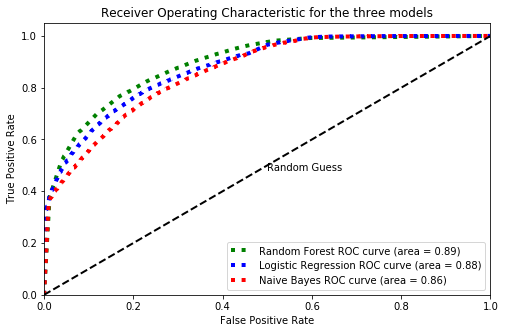

In [75]:
clf_pred_proba = (clf.predict_proba(features_test))[:,1]
fpr_rf, tpr_rf, threshold_rf = roc_curve(labels_test, clf_pred_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)

lrc_pred_proba = (lrc.predict_proba(features_test))[:,1]
fpr_lr, tpr_lr, threshold_lr = roc_curve(labels_test, lrc_pred_proba)
roc_auc_lrc = auc(fpr_lr, tpr_lr)

gnb_pred_proba = (gnb.predict_proba(features_test))[:,1]
fpr_gnb, tpr_gnb, threshold_gnb = roc_curve(labels_test, gnb_pred_proba)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)

plt.figure(figsize=(8,5))
plt.plot(fpr_rf, tpr_rf,
         label='Random Forest ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_rf),
         color='green', linestyle=':', linewidth=4)
plt.plot(fpr_lr, tpr_lr,
         label='Logistic Regression ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_lrc),
         color='blue', linestyle=':', linewidth=4)
plt.plot(fpr_gnb, tpr_gnb,
         label='Naive Bayes ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_gnb),
         color='red', linestyle=':', linewidth=4)

lw=2
plt.plot([0, 1], [0, 1], 'k--',color='black', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for the three models')
plt.legend(loc="lower right")
plt.show()

As you can see, the model with best performance is the Random Forest. This model is dominant over the other two models. 

## <a id = "uns">Unsupervised Models</a>

Now, we are going to use unsupervised statistical learning methods in order to compare the results with the supervised algorithms. In this section, we are going to implement a dimensionality reduction to the TF-IDF matrix using t-SNE, and then run a Gaussian Mixture model, using the Halinski Harabaz metric. 

Let's start with the t-SNE dimensionality reduction. Because we don't need the labels, nor split the data, we are going to build a new TF-IDF matrix:

In [76]:
vectorizer = TfidfVectorizer(min_df=50, stop_words="english")
X = vectorizer.fit_transform(data_models['text_parsed3'].sample(n = 1000))

And now we can run the dimensionality reduction algorithm. We already made the perplexity and learning rate tunning:

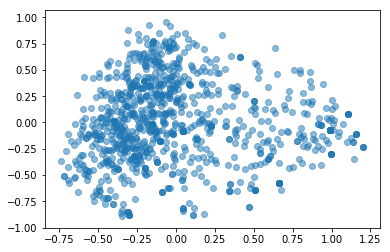

In [77]:
isomap = Isomap(n_neighbors = 200, n_components = 2)
swiss_roll_1d_isomap = isomap.fit_transform(X)
plt.scatter(swiss_roll_1d_isomap[:,0], swiss_roll_1d_isomap[:,1], alpha=0.5)

And now, we can run the Halinski Harabaz metric in order to find the optimal number of clusters:

In [78]:
%%capture 

best_score = -np.inf
best_k = None
best_model = None
best_cluster_assignation = None

for k in range(2, 11):
    candidate_gmm = GaussianMixture(n_components=k, n_init=100, random_state=0)
    candidate_gmm.fit(swiss_roll_1d_isomap)
    cluster_assignation = candidate_gmm.predict(swiss_roll_1d_isomap)
    score = calinski_harabaz_score(swiss_roll_1d_isomap, cluster_assignation)
    
    print('k =', k, 'have an index of', score)
    
    if score > best_score:
        best_score = score
        best_k = k
        best_model = candidate_gmm
        best_cluster_assignation = cluster_assignation
    
print('Best k among 2, 3, ..., 10 according to CH index:', best_k)

gmm = GaussianMixture(n_components=best_k, n_init=100, random_state=0)
gmm.fit(swiss_roll_1d_isomap)
gmm_cluster_asignation = gmm.predict(swiss_roll_1d_isomap)

(-0.8425589681610282,
 1.3091122072286145,
 -1.0013452324426728,
 1.0656670551290426)

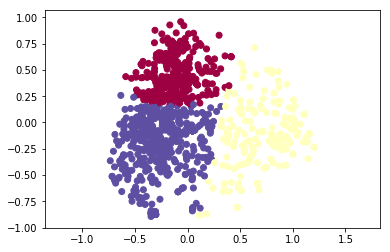

In [79]:
plt.scatter(swiss_roll_1d_isomap[:, 0], swiss_roll_1d_isomap[:, 1],
            c=best_cluster_assignation, cmap='Spectral')
plt.axis('equal')

From the results above, we can see that both unsupervised and supervised learning statistical methods got similar results. However, we should also noticed that the more data we include in our unsupervised model, the most accurate it is; this model takes to much memory and time to run, we just sample 1,000 observations. 

## <a id = "con">Conclusion</a>

Our analysis focused on scrapping twitter data using a list of words related with and without protests in Bolivia, Chile and Colombia. We compiled a dataset of 199,539 tweets that is balanced across countries and protests id, and we conducted descriptive analysis and train supervised and unsupervised models. Our results are fascinating. We were able to capture trends that are aling with the situation in each country: higher number of protests-related tweets since October, high participation of individuals across Latin America and also around North America, and a distribution of frequent words that is consisting with the situation in those countries. Moreover, by creating a set of words that are able to identify tweets completely different (protest and non-protest), both sets of models result in high performance. 

On one side, from the descriptive analysis we observed several differences between *protest* and *no protest* tweets. First, the activity level in Twitter increases whenever there's a *political hot-topic*, such as the ones related to the protests. For example, we could see high levels of activity the 20th of October, which was just after the electoral fraud in Bolivia. Another interesting pattern is that the majority of protest related tweets, were after 20.00 hrs. Second, the most common words in protest related tweets are `strike`, `law`, `security`, `people`, `chile has had enough`, `fraud`, and `government`. Also, words that are likely to go together are `national strike`, `curfew` (two words in spanish), `chile awake`. Moreover, in relation with the sentiment analysis, we found that despite the tweets are related to protests, their sentiment is neutral or positive. Finally, the majority of the users who tweeted about these topics are from Latin America, and even from countries that were not initially related to the protests, such as Mexico and Ecuador. 

On the other side, from the three supervised leaning statistical models: naive bayes, logistic regression, and random forest and its performance, ROC curve and the AUC, we found out that the model with best performance was the Random Forest. Also, we implemented an unsupervised learning statistical model: a Gaussian Mixture Model, after a dimensionality reduction. We compaired the results of both supervised and unsupervised models, finding a well defining two clusters. 

Finally, our visualization including the map and the word clouds are very informative about the situation. From these graphs we can draw conclusions about the social media patterns across individuals in Latin America. For instance, governments can use this type of analysis to understand individual's perception about their policies and/or predict whether their social media content is related to protest or not in order to diminish any collateral damage. We hope this analysis serves as basis for future work in understanding protests in Latin America. 

## <a id = "ref">References</a>

* Library `twitterscrapper`: https://github.com/taspinar/twitterscraper
* Trending tweets related with the protests: https://www.elespectador.com/tecnologia/de-que-habla-la-gente-en-twitter-durante-el-paro-articulo-893409
* Context Colombian Protests 2019: https://en.wikipedia.org/wiki/2019_Colombian_protests
* Tweets Analysis: https://towardsdatascience.com/analysis-of-tweets-on-the-hong-kong-protest-movement-2019-with-python-a331851f061
* Language validation: http://blog.manugarri.com/sentiment-analysis-in-spanish/
* Text translation: https://towardsdatascience.com/almost-real-time-twitter-sentiment-analysis-with-tweep-vader-f88ed5b93b1c